C:\Users\aadis\AppData\Local\Temp\ipykernel_14836\4074348457.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="5y", interval="1d")["Close"].dropna()
[*********************100%***********************]  6 of 6 completed


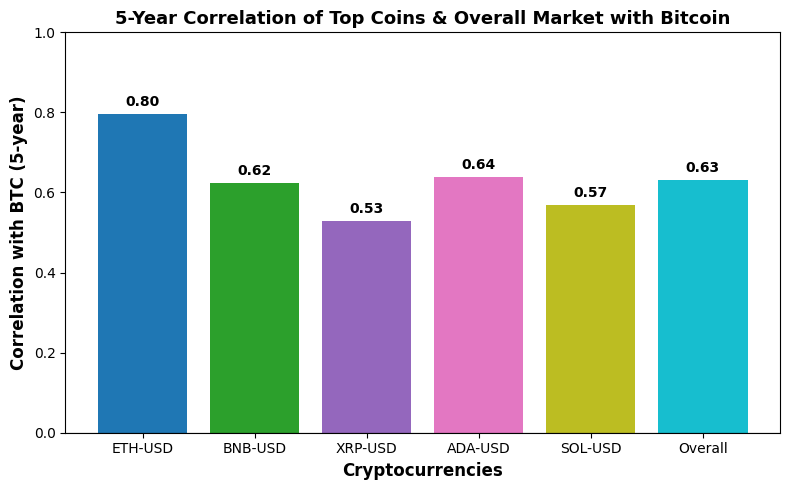

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tickers = ["BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "ADA-USD", "SOL-USD"]

# Download 5-year adjusted close prices
data = yf.download(tickers, period="5y", interval="1d")["Close"].dropna()

# Compute daily returns
returns = data.pct_change().dropna()

# Correlation with BTC
corr = {t: returns[t].corr(returns["BTC-USD"]) for t in tickers if t != "BTC-USD"}
corr["Overall"] = np.mean(list(corr.values()))

# Prepare data
labels = list(corr.keys())
values = [corr[k] for k in labels]

# Different color for each bar
colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(labels, values, color=colors)

# Styling
ax.set_ylim(0, 1)
ax.axhline(0, color="black", linewidth=0.8)
ax.set_ylabel("Correlation with BTC (5-year)", fontsize=12, fontweight="bold")
ax.set_xlabel("Cryptocurrencies", fontsize=12, fontweight="bold")
ax.set_title("5-Year Correlation of Top Coins & Overall Market with Bitcoin",
             fontsize=13, fontweight="bold")

# Annotate bars
for bar, v in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, v + 0.02, f"{v:.2f}",
            ha="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np

# ========== PARAMETERS ==========
tickers = ["BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "ADA-USD", "SOL-USD"]
periods = {"1Y": 252, "3Y": 252*3, "5Y": 252*5}
risk_free_rate = 0.0  # assume 0% for simplicity

# ========== DATA ==========
data = yf.download(tickers, period="5y", interval="1d")["Close"].dropna()
returns = data.pct_change().dropna()

# ========== PORTFOLIOS ==========
# Bitcoin only
btc_ret = returns["BTC-USD"]

# 1/N (exclude BTC)
others = [t for t in tickers if t != "BTC-USD"]
equal_1N = returns[others].mean(axis=1)

# Equal-weight across all
equal_all = returns.mean(axis=1)

# Combine for iteration
portfolios = {
    "Bitcoin Only": btc_ret,
    "1/N Crypto": equal_1N,
    "Equal-weighted (All)": equal_all
}

# ========== METRICS ==========
def sharpe_ratio(r):
    return np.sqrt(252) * (r.mean() - risk_free_rate) / r.std()

def cumulative_return(r):
    return (1 + r).prod() - 1

# Build results table
results = pd.DataFrame(index=portfolios.keys(), columns=[])
for label, series in portfolios.items():
    for name, length in periods.items():
        subset = series[-length:]
        sharpe = sharpe_ratio(subset)
        cumret = cumulative_return(subset)
        results.loc[label, f"{name} Sharpe"] = round(sharpe, 2)
        results.loc[label, f"{name} Cumulative Return (%)"] = round(cumret*100, 1)

# ========== OUTPUT ==========
print("\n=== Portfolio Performance Table ===")
print(results)


C:\Users\aadis\AppData\Local\Temp\ipykernel_14836\1452129850.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="5y", interval="1d")["Close"].dropna()
[*********************100%***********************]  6 of 6 completed


=== Portfolio Performance Table ===
                      1Y Sharpe  1Y Cumulative Return (%)  3Y Sharpe  \
Bitcoin Only               0.70                      19.9       1.50   
1/N Crypto                 0.67                      25.6       1.44   
Equal-weighted (All)       0.68                      25.7       1.49   

                      3Y Cumulative Return (%)  5Y Sharpe  \
Bitcoin Only                             370.4       0.76   
1/N Crypto                               551.5       0.68   
Equal-weighted (All)                     529.7       0.71   

                      5Y Cumulative Return (%)  
Bitcoin Only                             218.8  
1/N Crypto                               209.9  
Equal-weighted (All)                     222.5  


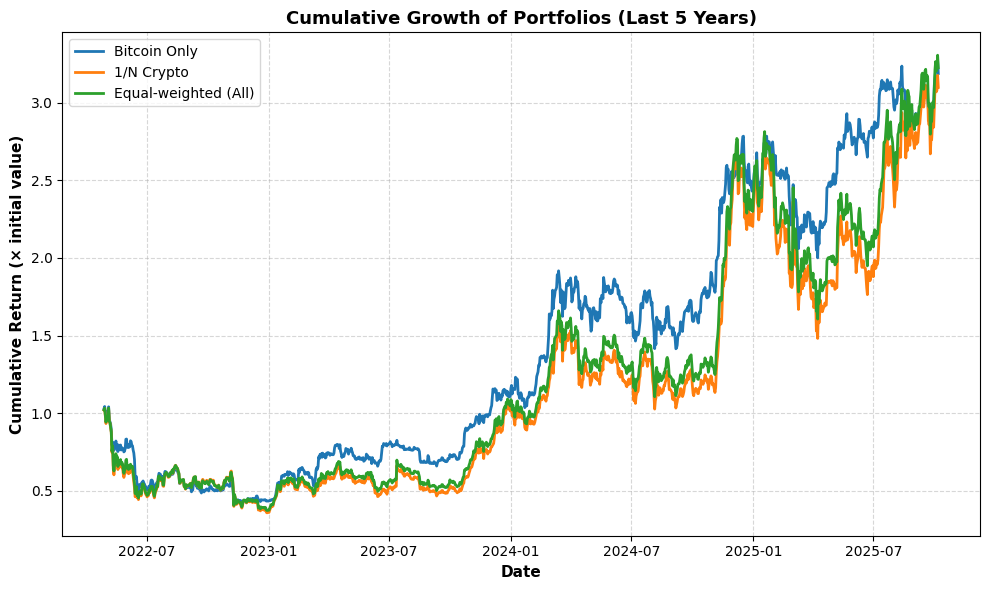

In [9]:
import matplotlib.pyplot as plt

# restrict to the same 5Y window
cutoff = returns.index[-252*5:]
btc_ret_5y = btc_ret.loc[cutoff]
equal_1N_5y = equal_1N.loc[cutoff]
equal_all_5y = equal_all.loc[cutoff]

cum = pd.DataFrame({
    "Bitcoin Only": (1 + btc_ret_5y).cumprod(),
    "1/N Crypto": (1 + equal_1N_5y).cumprod(),
    "Equal-weighted (All)": (1 + equal_all_5y).cumprod()
})

# Plot cumulative growth
plt.figure(figsize=(10, 6))
for col in cum.columns:
    plt.plot(cum.index, cum[col], label=col, linewidth=2)

plt.title("Cumulative Growth of Portfolios (Last 5 Years)", fontsize=13, fontweight="bold")
plt.xlabel("Date", fontsize=11, fontweight="bold")
plt.ylabel("Cumulative Return (× initial value)", fontsize=11, fontweight="bold")
# plt.yscale("log")  # optional, better readability for Bitcoin's explosive growth
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [10]:
def max_drawdown(series):
    cum = (1 + series).cumprod()
    running_max = cum.cummax()
    drawdown = cum / running_max - 1
    return drawdown.min() * 100  # percentage

metrics = pd.DataFrame(index=portfolios.keys(), columns=["5Y CumReturn (%)", "Max Drawdown (%)"])

for name, r in portfolios.items():
    subset = r[-252*5:]
    metrics.loc[name, "5Y CumReturn (%)"] = round((1 + subset).prod() - 1, 3) * 100
    metrics.loc[name, "Max Drawdown (%)"] = round(max_drawdown(subset), 1)

print(metrics)


                     5Y CumReturn (%) Max Drawdown (%)
Bitcoin Only                    218.8            -60.3
1/N Crypto                      209.9            -65.2
Equal-weighted (All)            222.5            -63.8


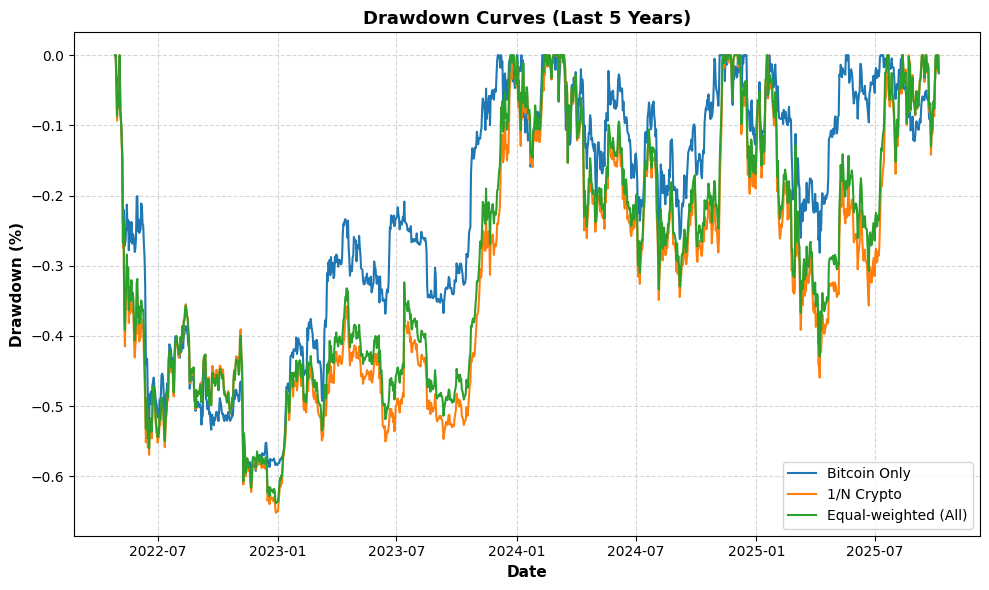

In [11]:
def drawdown_curve(r):
    cum = (1 + r).cumprod()
    return cum / cum.cummax() - 1

plt.figure(figsize=(10,6))
plt.plot(drawdown_curve(btc_ret[-252*5:]), label="Bitcoin Only")
plt.plot(drawdown_curve(equal_1N[-252*5:]), label="1/N Crypto")
plt.plot(drawdown_curve(equal_all[-252*5:]), label="Equal-weighted (All)")
plt.title("Drawdown Curves (Last 5 Years)", fontsize=13, fontweight="bold")
plt.ylabel("Drawdown (%)", fontsize=11, fontweight="bold")
plt.xlabel("Date", fontsize=11, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
